### Import all the necessary libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk 
import warnings 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
warnings.filterwarnings('ignore')

# Download necessary NLTK data (first time only)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to C:\Users\LAPTOP
[nltk_data]     LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\LAPTOP
[nltk_data]     LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LAPTOP
[nltk_data]     LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\LAPTOP LAB\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Load all the files and merge Test dataset and its labels

In [52]:
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')
test_df_label = pd.read_csv('sampleSubmission.csv')

In [53]:
test_df['Sentiment'] = test_df_label['Sentiment']

### Visualize the dataset before cleaning

In [54]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [55]:
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,2
1,156062,8545,An intermittently pleasing but mostly routine ...,2
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,2
4,156065,8545,intermittently pleasing but mostly routine,2


In [56]:
train_df.shape

(156060, 4)

In [57]:
test_df.shape

(66292, 4)

In [58]:
train_df['Sentiment'].value_counts(normalize=True)

Sentiment
2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: proportion, dtype: float64

+ Imbalance classes are seen

In [59]:
test_df['Sentiment'].value_counts(normalize=True)

Sentiment
2    1.0
Name: proportion, dtype: float64

+ Test dataset doesnt have any class label apart from 2

In [60]:
train_df["Phrase"][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [61]:
test_df["Phrase"][0]

'An intermittently pleasing but mostly routine effort .'

### Clean the datasets and Do Preprocessing on it.

In [62]:
def clean_text(df, column):
    translator = str.maketrans('', '', string.punctuation)
    df[column] = df[column].apply(lambda x: x.translate(translator) if isinstance(x, str) else x)
    df[column] = df[column].apply(lambda x: x.lower() if isinstance(x, str) else x)
    return df[column]

In [63]:
train_df["cleaned"] = clean_text(train_df, "Phrase")

In [64]:
test_df["cleaned"] = clean_text(test_df, "Phrase")

In [65]:
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,cleaned
0,156061,8545,an intermittently pleasing but mostly routine ...,2,an intermittently pleasing but mostly routine ...
1,156062,8545,an intermittently pleasing but mostly routine ...,2,an intermittently pleasing but mostly routine ...
2,156063,8545,an,2,an
3,156064,8545,intermittently pleasing but mostly routine effort,2,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine,2,intermittently pleasing but mostly routine


In [66]:
def preprocess_text(text, use_stemming=True):
    if not isinstance(text, str):
        return ''
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    if use_stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    else:
        tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return ' '.join(tokens)

In [67]:
train_df['cleaned_text'] = train_df['cleaned'].apply(lambda x: preprocess_text(x, use_stemming=False))

In [68]:
test_df['cleaned_text'] = test_df['cleaned'].apply(lambda x: preprocess_text(x, use_stemming=False))

In [69]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,cleaned,cleaned_text
0,1,1,a series of escapades demonstrating the adage ...,1,a series of escapades demonstrating the adage ...,series escapades demonstrate adage good goose ...
1,2,1,a series of escapades demonstrating the adage ...,2,a series of escapades demonstrating the adage ...,series escapades demonstrate adage good goose
2,3,1,a series,2,a series,series
3,4,1,a,2,a,
4,5,1,series,2,series,series


In [70]:
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment,cleaned,cleaned_text
0,156061,8545,an intermittently pleasing but mostly routine ...,2,an intermittently pleasing but mostly routine ...,intermittently please mostly routine effort
1,156062,8545,an intermittently pleasing but mostly routine ...,2,an intermittently pleasing but mostly routine ...,intermittently please mostly routine effort
2,156063,8545,an,2,an,
3,156064,8545,intermittently pleasing but mostly routine effort,2,intermittently pleasing but mostly routine effort,intermittently please mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine,2,intermittently pleasing but mostly routine,intermittently please mostly routine


In [71]:
train_df["cleaned_text"][0]

'series escapades demonstrate adage good goose also good gander occasionally amuse none amount much story'

In [72]:
test_df["cleaned_text"][0]

'intermittently please mostly routine effort'

In [73]:
train_df[train_df['cleaned_text'] == '']

,PhraseId,SentenceId,Phrase,Sentiment,cleaned,cleaned_text
3,4,1,a,2,a,
6,7,1,of,2,of,
13,14,1,the,2,the,
16,17,1,that,2,that,
18,19,1,what,2,what,
...,...,...,...,...,...,...
154523,154524,8446,the same all over,2,the same all over,
154524,154525,8446,all over,2,all over,
154864,154865,8470,as 8,2,as 8,
154867,154868,8471,but no,1,but no,


In [74]:
test_df[test_df['cleaned_text'] == '']

,PhraseId,SentenceId,Phrase,Sentiment,cleaned,cleaned_text
2,156063,8545,an,2,an,
9,156070,8545,but,2,but,
14,156075,8545,,2,,
20,156081,8546,is,2,is,
24,156085,8546,the,2,the,
...,...,...,...,...,...,...
66087,222148,11842,just did,2,just did,
66088,222149,11842,did,2,did,
66216,222277,11850,but,2,but,
66249,222310,11852,if you,2,if you,


+ After removing stop words some blank rows are seen we will drop them.

In [75]:
train_df = train_df[train_df['cleaned_text'] != '']

In [76]:
test_df = test_df[test_df['cleaned_text'] != '']

### Using TFIDF Method to convert our cleaned text into vectors.

In [77]:
tfidf_vectorizer = TfidfVectorizer()

train_tfidf = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
test_tfidf = tfidf_vectorizer.transform(test_df['cleaned_text'])

## Logistics Regression Using TFIDF Vectors

In [78]:
log_reg_tfidf = LogisticRegression(random_state=42)
log_reg_tfidf.fit(train_tfidf, train_df["Sentiment"])

LogisticRegression(random_state=42)

## Evaluation of Logistics Regression 

Logistics Regression Accuracy: 0.6879407724011601


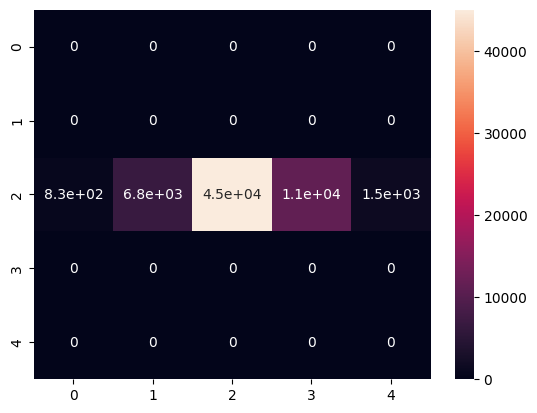

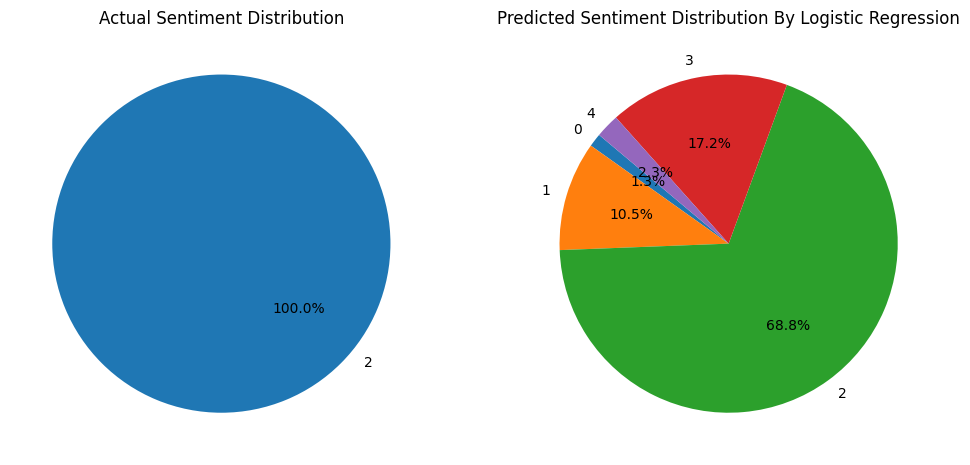

In [79]:
actual_labels = test_df["Sentiment"].tolist()
predictions = log_reg_tfidf.predict(test_tfidf).tolist()

accuracy = accuracy_score(test_df['Sentiment'], predictions)
print("Logistics Regression Accuracy:", accuracy)
sns.heatmap(confusion_matrix(test_df['Sentiment'], predictions),annot=True)

sentiment_counts = {label: actual_labels.count(label) for label in set(actual_labels)}
sentiment_counts2 = {label: predictions.count(label) for label in set(predictions)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
ax1.set_title('Actual Sentiment Distribution')

ax2.pie(sentiment_counts2.values(), labels=sentiment_counts2.keys(), autopct='%1.1f%%', startangle=140)
ax2.set_title('Predicted Sentiment Distribution By Logistic Regression')

plt.show()

+ Since our test dataset just have 1 label so model seems fine for it but not the good.

## Naive Bayes Using TFIDF Vectors

In [80]:
nb_model_tfidf = MultinomialNB()
nb_model_tfidf.fit(train_tfidf, train_df["Sentiment"])

MultinomialNB()

## Evaluation of Naive Bayes

Naive Bayes Accuracy: 0.786231109754236


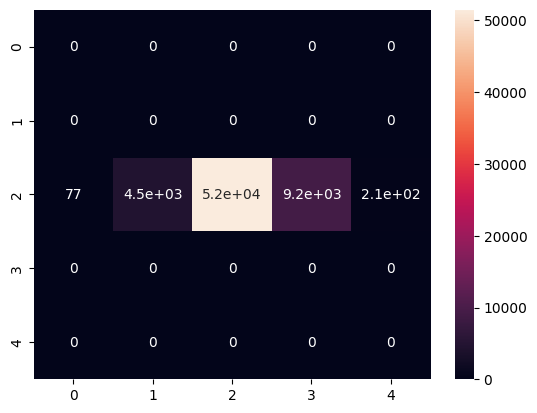

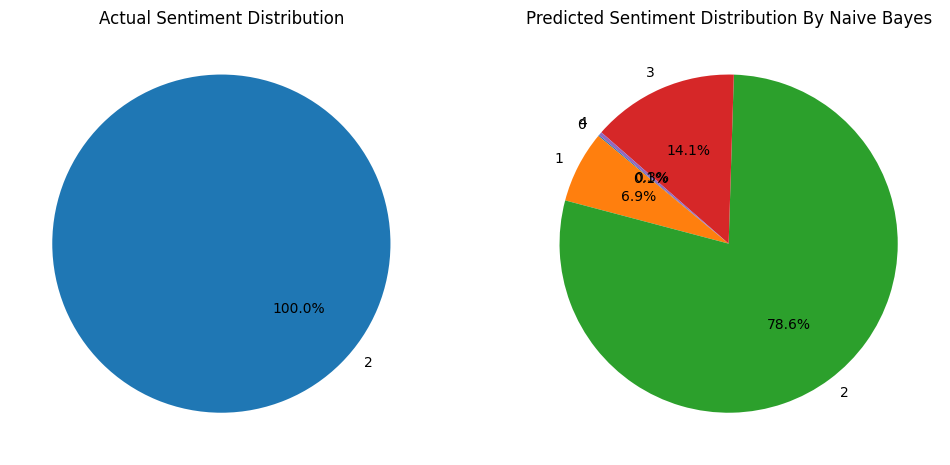

In [81]:
actual_labels = test_df["Sentiment"].tolist()
y_pred_nb = nb_model_tfidf.predict(test_tfidf).tolist()

accuracy = accuracy_score(test_df['Sentiment'], y_pred_nb)
print("Naive Bayes Accuracy:", accuracy)
sns.heatmap(confusion_matrix(test_df['Sentiment'], y_pred_nb),annot=True)

sentiment_counts = {label: actual_labels.count(label) for label in set(actual_labels)}
sentiment_counts2 = {label: y_pred_nb.count(label) for label in set(y_pred_nb)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
ax1.set_title('Actual Sentiment Distribution')

ax2.pie(sentiment_counts2.values(), labels=sentiment_counts2.keys(), autopct='%1.1f%%', startangle=140)
ax2.set_title('Predicted Sentiment Distribution By Naive Bayes')

plt.show()

+ Model seems to work better than Logistic Regression and almost ignored all wrong classifications of 0 and 4 labels

### Using Count Vector Method to convert our cleaned text into vectors.

In [82]:
count_vectorizer = CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train_df['cleaned_text'])
test_vectors = count_vectorizer.transform(test_df["cleaned_text"])

## Logistics Regression Using Count Vectors

In [83]:
log_reg_cv = LogisticRegression(random_state=42)
log_reg_cv.fit(train_vectors, train_df["Sentiment"])

LogisticRegression(random_state=42)

## Evaluation of Logistic Regression

Logistics Regression Accuracy: 0.681147916348649


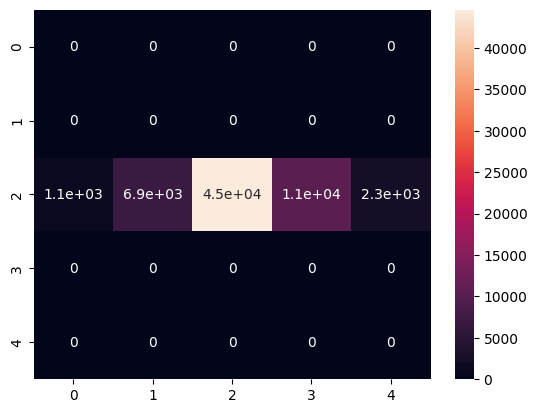

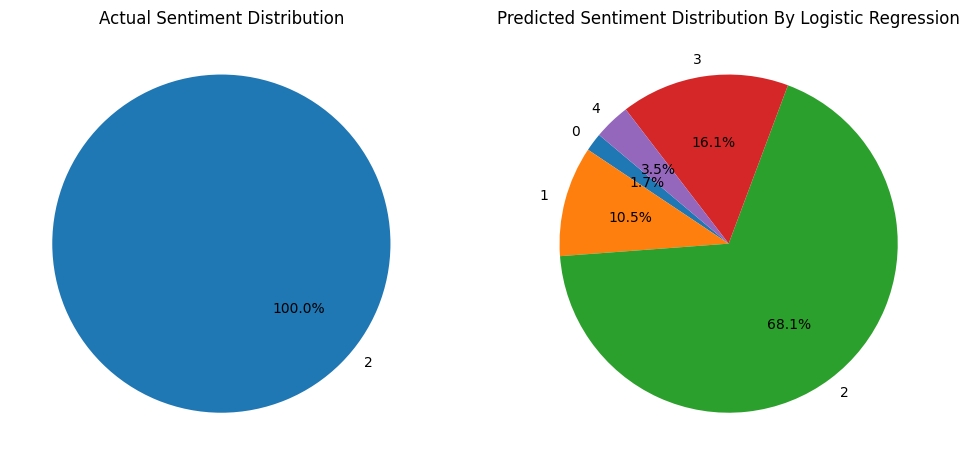

In [84]:
actual_labels = test_df["Sentiment"].tolist()
predictions = log_reg_cv.predict(test_vectors).tolist()

accuracy = accuracy_score(test_df['Sentiment'], predictions)
print("Logistics Regression Accuracy:", accuracy)
sns.heatmap(confusion_matrix(test_df['Sentiment'], predictions),annot=True)

sentiment_counts = {label: actual_labels.count(label) for label in set(actual_labels)}
sentiment_counts2 = {label: predictions.count(label) for label in set(predictions)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
ax1.set_title('Actual Sentiment Distribution')

ax2.pie(sentiment_counts2.values(), labels=sentiment_counts2.keys(), autopct='%1.1f%%', startangle=140)
ax2.set_title('Predicted Sentiment Distribution By Logistic Regression')

plt.show()

+ Not much difference in performance of Logistic Regression by using either of the vector converting methods.

## Naive Bayes Using Count Vectors

In [85]:
nb_model_cv = MultinomialNB()
nb_model_cv.fit(train_vectors, train_df["Sentiment"])

MultinomialNB()

## Evaluation of Naive Bayes

Naive Bayes Accuracy: 0.6570294611509693


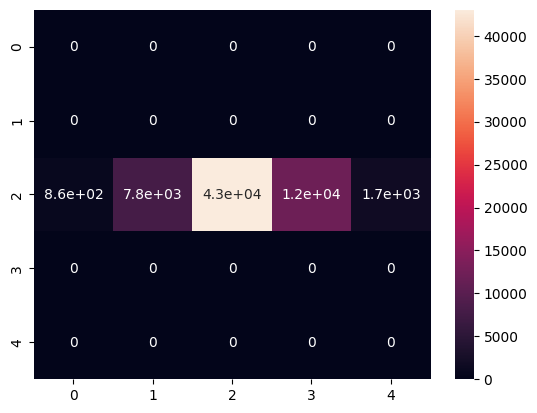

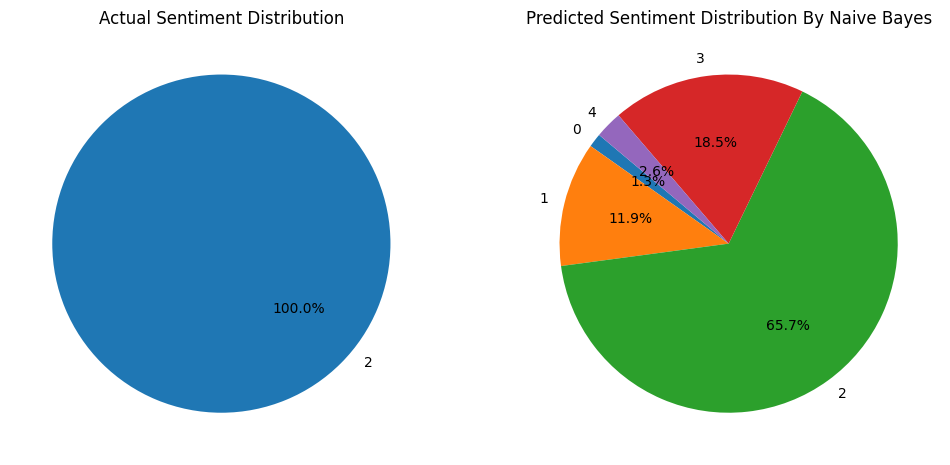

In [86]:
actual_labels = test_df["Sentiment"].tolist()
y_pred_nb = nb_model_cv.predict(test_vectors).tolist()

accuracy = accuracy_score(test_df['Sentiment'], y_pred_nb)
print("Naive Bayes Accuracy:", accuracy)
sns.heatmap(confusion_matrix(test_df['Sentiment'], y_pred_nb),annot=True)

sentiment_counts = {label: actual_labels.count(label) for label in set(actual_labels)}
sentiment_counts2 = {label: y_pred_nb.count(label) for label in set(y_pred_nb)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', startangle=140)
ax1.set_title('Actual Sentiment Distribution')

ax2.pie(sentiment_counts2.values(), labels=sentiment_counts2.keys(), autopct='%1.1f%%', startangle=140)
ax2.set_title('Predicted Sentiment Distribution By Naive Bayes')

plt.show()

+ Poor performance compare to other models.

In [87]:
model_metrics = {
    "Model Name": [],
    "Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1-Score": []
}

model1 = log_reg_tfidf
model2 = log_reg_cv
model3 = nb_model_tfidf
model4 = nb_model_cv

actual_labels = test_df["Sentiment"].tolist()

predicted_labels1 = model1.predict(test_tfidf)
predicted_labels2 = model2.predict(test_vectors)
predicted_labels3 = model3.predict(test_tfidf)
predicted_labels4 = model4.predict(test_vectors)

for model, predictions in zip(["Logistic Regression - TFIDF", "Logistic Regression - CV", "Naive Bayes - TFIDF", "Naive Bayes - CV"], [predicted_labels1, predicted_labels2, predicted_labels3, predicted_labels4]):
    accuracy = accuracy_score(actual_labels, predictions)
    recall = recall_score(actual_labels, predictions, average='weighted')
    precision = precision_score(actual_labels, predictions, average='weighted')
    f1 = f1_score(actual_labels, predictions, average='weighted')

    model_metrics["Model Name"].append(model)
    model_metrics["Accuracy"].append(accuracy)
    model_metrics["Recall"].append(recall)
    model_metrics["Precision"].append(precision)
    model_metrics["F1-Score"].append(f1)

df = pd.DataFrame(model_metrics)

print(df)

                    Model Name  Accuracy    Recall  Precision  F1-Score
0  Logistic Regression - TFIDF  0.687941  0.687941        1.0  0.815124
1     Logistic Regression - CV  0.681148  0.681148        1.0  0.810337
2          Naive Bayes - TFIDF  0.786231  0.786231        1.0  0.880324
3             Naive Bayes - CV  0.657029  0.657029        1.0  0.793021


# **Our Best Performing Model is Naive Bayes Using the TFIDF vector method**